In [51]:
import sys
sys.path.append(r'E:\nonogram_player')

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras
from collections import Counter
from tensorflow.keras.regularizers import l2

from src.opencv._common import scale_image_to_100x100
from typing import Dict


input_shape = (100, 100)
batch_size = 32
epochs = 100

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,  # [0.7 -> 1.3]
    rescale=1./255,  # Convert 'large' RGB (255) to floats (1.0)

    validation_split=0.3,

    preprocessing_function=scale_image_to_100x100,
)

train_data = datagen.flow_from_directory(
    './images',
    target_size=input_shape,
    batch_size=batch_size,
    interpolation="lanczos",
    shuffle=True,
    subset='training',
)

validation_data = datagen.flow_from_directory(
    './images',
    target_size=input_shape,
    batch_size=batch_size,
    interpolation="lanczos",
    shuffle=True,
    subset='validation',
)


def get_class_weights(train) -> Dict[int, float]:
    itemCt = Counter(train.classes)
    maxCt = float(max(itemCt.values()))
    return {clsID: maxCt/numImg for clsID, numImg in itemCt.items()}


Found 1521 images belonging to 10 classes.
Found 647 images belonging to 10 classes.


In [52]:
train_data.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [53]:
get_class_weights(train_data)

{0: 18.071428571428573,
 1: 1.0,
 2: 1.726962457337884,
 3: 2.594871794871795,
 4: 3.0481927710843375,
 5: 4.3247863247863245,
 6: 7.027777777777778,
 7: 7.126760563380282,
 8: 13.31578947368421,
 9: 14.457142857142857}

In [64]:
def print_history(hist):
    for k in hist.history.keys():
        if k.startswith('val_'):
            continue

        try:
            # summarize history for accuracy
            plt.plot(hist.history[k])
            plt.plot(hist.history['val_' + k])
            plt.title('model ' + k)
            plt.ylabel(k)
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()
        except KeyError:
            pass

        
class StopTrainingIfEnoughAcc(keras.callbacks.Callback):
    # https://medium.com/analytics-vidhya/transfer-learning-using-inception-v3-for-image-classification-86700411251b
    def on_epoch_end(self, epoch, logs={}):
        # Available in logs: 'loss', 'accuracy', 'val_<same>'
        if logs['accuracy'] > 0.99:
            print(f"\nGot to accuracy '{logs.get('accuracy')*100:.2f}%'")
            self.model.stop_training = True

def do_fit(model, train, test, tgt, epochs=20_000):
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=1e-18, verbose=1),
        EarlyStopping(monitor='val_loss', patience=20, verbose=1),
        ModelCheckpoint(f'./{tgt}/epoch_{{epoch:03d}}-acc_{{accuracy:.5f}}-valacc_{{val_accuracy:.5f}}.hdf5', monitor='accuracy', initial_value_threshold=0.85, verbose=1, save_best_only=True, mode='max'),
        # StopTrainingIfEnoughAcc(),
    ]

    model.summary()

    hist = model.fit(
        train,
        validation_data=test,
        epochs=epochs,  # We do early stopping. So this will always stop before this point
        shuffle=True,
        callbacks=callbacks,
        verbose=1,
        # class_weight=get_class_weights(train),
    )

    print_history(hist)

    globals()[f'{tgt}_hist'] = hist

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 96, 96, 32)        2432      
                                                                 
 conv2d_125 (Conv2D)         (None, 92, 92, 32)        25600     
                                                                 
 batch_normalization_99 (Bat  (None, 92, 92, 32)       128       
 chNormalization)                                                
                                                                 
 activation_99 (Activation)  (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 46, 46, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 46, 46, 32)      

Epoch 11/20000
48/48 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9829
Epoch 11: accuracy did not improve from 0.98356
48/48 [==============================] - 5s 96ms/step - loss: 0.1403 - accuracy: 0.9829 - val_loss: 0.7878 - val_accuracy: 0.7527 - lr: 4.0000e-05
Epoch 12/20000
48/48 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9822
Epoch 12: accuracy did not improve from 0.98356
48/48 [==============================] - 5s 97ms/step - loss: 0.1441 - accuracy: 0.9822 - val_loss: 0.5881 - val_accuracy: 0.8192 - lr: 4.0000e-05
Epoch 13/20000
48/48 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9836
Epoch 13: accuracy did not improve from 0.98356
48/48 [==============================] - 5s 98ms/step - loss: 0.1293 - accuracy: 0.9836 - val_loss: 0.4456 - val_accuracy: 0.8764 - lr: 4.0000e-05
Epoch 14/20000
48/48 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9790
Epoch 14: accuracy did 

48/48 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9901
Epoch 36: accuracy did not improve from 0.99211
48/48 [==============================] - 5s 99ms/step - loss: 0.1127 - accuracy: 0.9901 - val_loss: 0.1542 - val_accuracy: 0.9722 - lr: 5.1200e-10
Epoch 37/20000
48/48 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9888
Epoch 37: accuracy did not improve from 0.99211
48/48 [==============================] - 5s 95ms/step - loss: 0.1207 - accuracy: 0.9888 - val_loss: 0.1032 - val_accuracy: 0.9923 - lr: 5.1200e-10
Epoch 38/20000
48/48 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9908
Epoch 38: accuracy did not improve from 0.99211
48/48 [==============================] - 5s 97ms/step - loss: 0.1062 - accuracy: 0.9908 - val_loss: 0.1079 - val_accuracy: 0.9907 - lr: 5.1200e-10
Epoch 39/20000
48/48 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9908
Epoch 39: ReduceLROnPlateau reducing l

Epoch 61/20000
48/48 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9915
Epoch 61: ReduceLROnPlateau reducing learning rate to 1.0485760990728867e-17.

Epoch 61: accuracy did not improve from 0.99606
48/48 [==============================] - 5s 95ms/step - loss: 0.1059 - accuracy: 0.9915 - val_loss: 0.1138 - val_accuracy: 0.9892 - lr: 5.2429e-17
Epoch 62/20000
48/48 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9915
Epoch 62: accuracy did not improve from 0.99606
48/48 [==============================] - 5s 95ms/step - loss: 0.1154 - accuracy: 0.9915 - val_loss: 0.1215 - val_accuracy: 0.9815 - lr: 1.0486e-17
Epoch 63/20000
48/48 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9895
Epoch 63: ReduceLROnPlateau reducing learning rate to 2.097152165058549e-18.

Epoch 63: accuracy did not improve from 0.99606
48/48 [==============================] - 5s 97ms/step - loss: 0.1098 - accuracy: 0.9895 - val_loss: 0.1188 - va

48/48 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9901
Epoch 88: accuracy did not improve from 0.99606
48/48 [==============================] - 5s 98ms/step - loss: 0.1146 - accuracy: 0.9901 - val_loss: 0.1243 - val_accuracy: 0.9768 - lr: 1.0000e-18
Epoch 89/20000
48/48 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9901
Epoch 89: accuracy did not improve from 0.99606
48/48 [==============================] - 5s 100ms/step - loss: 0.1169 - accuracy: 0.9901 - val_loss: 0.1257 - val_accuracy: 0.9845 - lr: 1.0000e-18
Epoch 90/20000
48/48 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9888
Epoch 90: accuracy did not improve from 0.99606
48/48 [==============================] - 5s 98ms/step - loss: 0.1108 - accuracy: 0.9888 - val_loss: 0.1208 - val_accuracy: 0.9845 - lr: 1.0000e-18
Epoch 91/20000
48/48 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9928
Epoch 91: accuracy did not improve fr

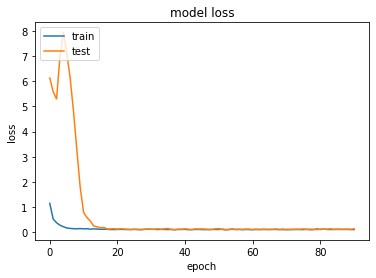

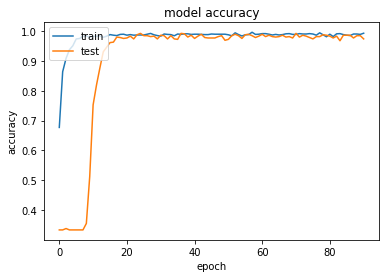

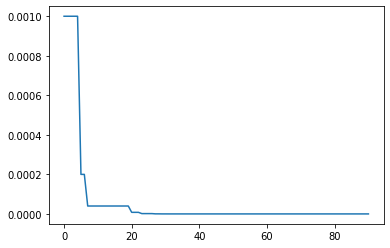

In [57]:
# https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392

model = Sequential([
    Input(input_shape + (3,)),
    
    Conv2D(32, kernel_size=5, strides=1, activation='relu', kernel_regularizer=l2(0.0005)),
    Conv2D(32, kernel_size=5, strides=1, use_bias=False),
    
    BatchNormalization(),
    
    Activation("relu"),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(0.25),

    Conv2D(64, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.0005)),
    Conv2D(64, kernel_size=3, strides=1, use_bias=False),

    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(0.25),

    Conv2D(128, kernel_size=3, strides=1, activation='relu', kernel_regularizer=l2(0.0005)),
    Conv2D(128, kernel_size=3, strides=1, use_bias=False),

    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(0.25),

    Flatten(),
    
    Dense(2048, use_bias=False),
    BatchNormalization(),
    Activation("relu"),

    Dense(128, use_bias=False),
    BatchNormalization(),
    Activation("relu"),

    Dropout(0.25),

    Dense(train_data.num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model_medium')


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 conv2d_131 (Conv2D)         (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_132 (Conv2D)         (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_133 (Conv2D)         (None, 21, 21, 256)     

48/48 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9862
Epoch 19: accuracy did not improve from 0.98948
48/48 [==============================] - 5s 95ms/step - loss: 0.0452 - accuracy: 0.9862 - val_loss: 0.0233 - val_accuracy: 0.9954 - lr: 4.0000e-05
Epoch 20/20000
48/48 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9921
Epoch 20: accuracy improved from 0.98948 to 0.99211, saving model to ./model_pdf\epoch_020-acc_0.99211-valacc_0.99227.hdf5
48/48 [==============================] - 5s 96ms/step - loss: 0.0293 - accuracy: 0.9921 - val_loss: 0.0188 - val_accuracy: 0.9923 - lr: 4.0000e-05
Epoch 21/20000
48/48 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9934
Epoch 21: accuracy improved from 0.99211 to 0.99343, saving model to ./model_pdf\epoch_021-acc_0.99343-valacc_0.99227.hdf5
48/48 [==============================] - 5s 96ms/step - loss: 0.0261 - accuracy: 0.9934 - val_loss: 0.0273 - val_accuracy: 0.9923 - l

Epoch 44/20000
48/48 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9928
Epoch 44: accuracy did not improve from 0.99540
48/48 [==============================] - 6s 116ms/step - loss: 0.0269 - accuracy: 0.9928 - val_loss: 0.0226 - val_accuracy: 0.9923 - lr: 4.0960e-12
Epoch 45/20000
48/48 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9934
Epoch 45: ReduceLROnPlateau reducing learning rate to 8.192000897078167e-13.

Epoch 45: accuracy did not improve from 0.99540
48/48 [==============================] - 5s 95ms/step - loss: 0.0232 - accuracy: 0.9934 - val_loss: 0.0179 - val_accuracy: 0.9938 - lr: 4.0960e-12
Epoch 46/20000
48/48 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9934
Epoch 46: accuracy did not improve from 0.99540
48/48 [==============================] - 5s 95ms/step - loss: 0.0259 - accuracy: 0.9934 - val_loss: 0.0242 - val_accuracy: 0.9907 - lr: 8.1920e-13
Epoch 47/20000
48/48 [====================

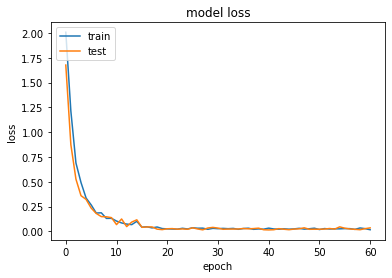

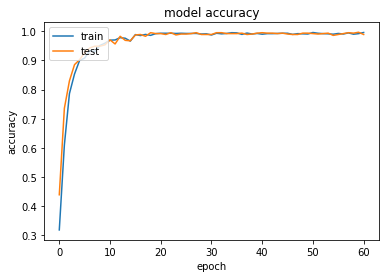

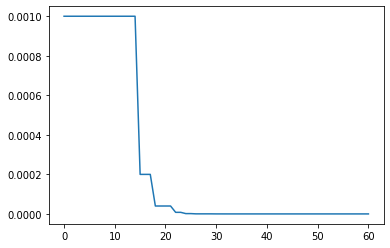

In [58]:
model = Sequential()
model.add(Input(input_shape + (3,)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(train_data.num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model_pdf')


Epoch 1/20000
48/48 [==============================] - ETA: 0s - loss: 2.7884 - accuracy: 0.3110
Epoch 1: accuracy did not improve from 0.85000
48/48 [==============================] - 5s 104ms/step - loss: 2.7884 - accuracy: 0.3110 - val_loss: 1.6190 - val_accuracy: 0.5209 - lr: 0.0010
Epoch 2/20000
47/48 [============================>.] - ETA: 0s - loss: 1.4573 - accuracy: 0.5293
Epoch 2: accuracy did not improve from 0.85000
48/48 [==============================] - 5s 104ms/step - loss: 1.4568 - accuracy: 0.5306 - val_loss: 1.0851 - val_accuracy: 0.6615 - lr: 0.0010
Epoch 3/20000
48/48 [==============================] - ETA: 0s - loss: 1.1534 - accuracy: 0.6187
Epoch 3: accuracy did not improve from 0.85000
48/48 [==============================] - 5s 99ms/step - loss: 1.1534 - accuracy: 0.6187 - val_loss: 0.9044 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 4/20000
48/48 [==============================] - ETA: 0s - loss: 1.0052 - accuracy: 0.6713
Epoch 4: accuracy did not improve from 0

Epoch 28/20000
48/48 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.9007
Epoch 28: accuracy did not improve from 0.90664
48/48 [==============================] - 5s 102ms/step - loss: 0.2756 - accuracy: 0.9007 - val_loss: 0.1061 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 29/20000
48/48 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9099
Epoch 29: accuracy improved from 0.90664 to 0.90993, saving model to ./model1\epoch_029-0.96600.hdf5
48/48 [==============================] - 7s 156ms/step - loss: 0.2708 - accuracy: 0.9099 - val_loss: 0.1092 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 30/20000
48/48 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9014
Epoch 30: accuracy did not improve from 0.90993
48/48 [==============================] - 5s 94ms/step - loss: 0.2685 - accuracy: 0.9014 - val_loss: 0.1243 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 31/20000
48/48 [==============================] - ETA: 0s - loss: 0.2731

48/48 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9448
Epoch 54: accuracy did not improve from 0.94872
48/48 [==============================] - 5s 94ms/step - loss: 0.1714 - accuracy: 0.9448 - val_loss: 0.0622 - val_accuracy: 0.9876 - lr: 1.0000e-06
Epoch 55/20000
48/48 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9369
Epoch 55: accuracy did not improve from 0.94872
48/48 [==============================] - 5s 95ms/step - loss: 0.1696 - accuracy: 0.9369 - val_loss: 0.0523 - val_accuracy: 0.9845 - lr: 1.0000e-06
Epoch 56/20000
48/48 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9343
Epoch 56: accuracy did not improve from 0.94872
48/48 [==============================] - 5s 94ms/step - loss: 0.1865 - accuracy: 0.9343 - val_loss: 0.0690 - val_accuracy: 0.9830 - lr: 1.0000e-06
Epoch 56: early stopping


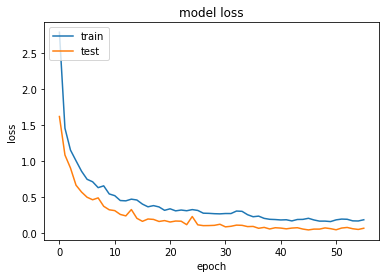

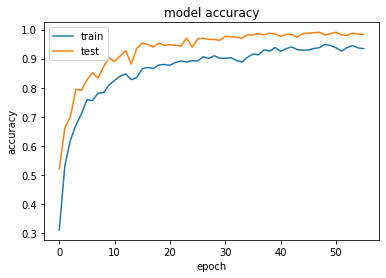

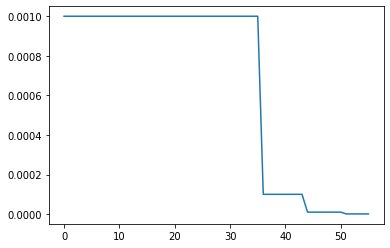

In [31]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape + (3,)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_data.num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model1')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_134 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 49, 49, 32)        0         
                                                                 
 conv2d_135 (Conv2D)         (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 23, 23, 64)      

Epoch 19/20000
48/48 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9645
Epoch 19: accuracy improved from 0.94675 to 0.96450, saving model to ./model2\epoch_019-acc_0.96450-valacc_0.97063.hdf5
48/48 [==============================] - 10s 203ms/step - loss: 0.1091 - accuracy: 0.9645 - val_loss: 0.0983 - val_accuracy: 0.9706 - lr: 2.0000e-04
Epoch 20/20000
48/48 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9612
Epoch 20: accuracy did not improve from 0.96450
48/48 [==============================] - 4s 92ms/step - loss: 0.1132 - accuracy: 0.9612 - val_loss: 0.1259 - val_accuracy: 0.9567 - lr: 2.0000e-04
Epoch 21/20000
48/48 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9599
Epoch 21: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 21: accuracy did not improve from 0.96450
48/48 [==============================] - 4s 93ms/step - loss: 0.1158 - accuracy: 0.9599 - val_loss: 0.1299 - val_ac

Epoch 43/20000
48/48 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9684
Epoch 43: accuracy did not improve from 0.97436
48/48 [==============================] - 4s 91ms/step - loss: 0.0947 - accuracy: 0.9684 - val_loss: 0.0942 - val_accuracy: 0.9614 - lr: 2.0480e-11
Epoch 44/20000
48/48 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9711
Epoch 44: ReduceLROnPlateau reducing learning rate to 4.096000622011431e-12.

Epoch 44: accuracy did not improve from 0.97436
48/48 [==============================] - 4s 93ms/step - loss: 0.0883 - accuracy: 0.9711 - val_loss: 0.1159 - val_accuracy: 0.9583 - lr: 2.0480e-11
Epoch 45/20000
48/48 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9757
Epoch 45: accuracy improved from 0.97436 to 0.97567, saving model to ./model2\epoch_045-acc_0.97567-valacc_0.96754.hdf5
48/48 [==============================] - 10s 203ms/step - loss: 0.0817 - accuracy: 0.9757 - val_loss: 0.1043 - val_acc

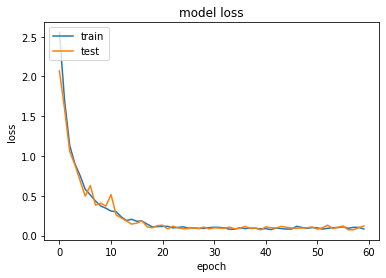

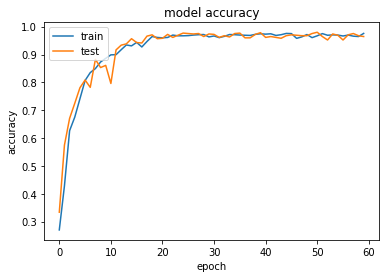

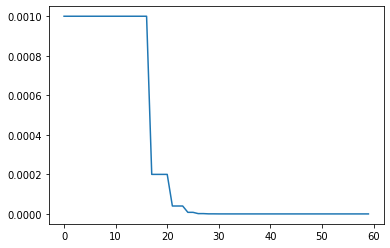

In [59]:
model = Sequential()
model.add(Input(shape=input_shape + (3,)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(train_data.num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model2')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 30000)             0         
                                                                 
 dense_38 (Dense)            (None, 1024)              30721024  
                                                                 
 dense_39 (Dense)            (None, 256)               262400    
                                                                 
 dense_40 (Dense)            (None, 128)               32896     
                                                                 
 dense_41 (Dense)            (None, 10)                1290      
                                                                 
Total params: 31,017,610
Trainable params: 31,017,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20000
48/48 [====================


Epoch 24: accuracy did not improve from 0.85000
48/48 [==============================] - 5s 94ms/step - loss: 0.9408 - accuracy: 0.7535 - val_loss: 0.9049 - val_accuracy: 0.7481 - lr: 1.6000e-06
Epoch 25/20000
48/48 [==============================] - ETA: 0s - loss: 0.9083 - accuracy: 0.7403
Epoch 25: accuracy did not improve from 0.85000
48/48 [==============================] - 4s 93ms/step - loss: 0.9083 - accuracy: 0.7403 - val_loss: 0.9755 - val_accuracy: 0.7311 - lr: 3.2000e-07
Epoch 26/20000
48/48 [==============================] - ETA: 0s - loss: 0.9584 - accuracy: 0.7350
Epoch 26: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.

Epoch 26: accuracy did not improve from 0.85000
48/48 [==============================] - 5s 95ms/step - loss: 0.9584 - accuracy: 0.7350 - val_loss: 1.0569 - val_accuracy: 0.7125 - lr: 3.2000e-07
Epoch 27/20000
48/48 [==============================] - ETA: 0s - loss: 0.9301 - accuracy: 0.7298
Epoch 27: accuracy did not improve from 0.

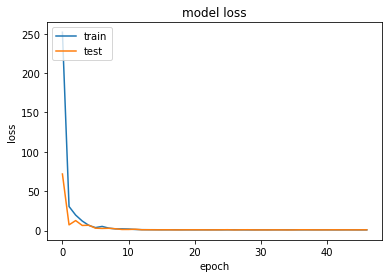

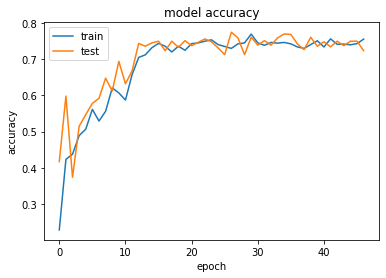

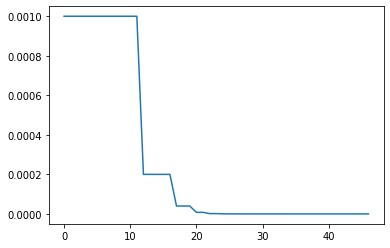

In [60]:
model = Sequential()
model.add(Input(shape=input_shape + (3,)))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense(train_data.num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model3')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_136 (Conv2D)         (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_137 (Conv2D)         (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_138 (Conv2D)         (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 12, 12, 64)     

48/48 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9684
Epoch 19: accuracy improved from 0.95858 to 0.96844, saving model to ./model4\epoch_019-acc_0.96844-valacc_0.99691.hdf5
48/48 [==============================] - 5s 101ms/step - loss: 0.0891 - accuracy: 0.9684 - val_loss: 0.0166 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 20/20000
48/48 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9638
Epoch 20: accuracy did not improve from 0.96844
48/48 [==============================] - 4s 92ms/step - loss: 0.1052 - accuracy: 0.9638 - val_loss: 0.0340 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 21/20000
48/48 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9638
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 21: accuracy did not improve from 0.96844
48/48 [==============================] - 4s 92ms/step - loss: 0.0975 - accuracy: 0.9638 - val_loss: 0.0422 - val_accuracy: 0.9876 - lr: 0.0

Epoch 44/20000
48/48 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9796
Epoch 44: accuracy did not improve from 0.98685
48/48 [==============================] - 4s 92ms/step - loss: 0.0617 - accuracy: 0.9796 - val_loss: 0.0094 - val_accuracy: 0.9985 - lr: 2.5600e-09
Epoch 45/20000
48/48 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9829
Epoch 45: ReduceLROnPlateau reducing learning rate to 5.1200004236307e-10.

Epoch 45: accuracy did not improve from 0.98685
48/48 [==============================] - 4s 92ms/step - loss: 0.0489 - accuracy: 0.9829 - val_loss: 0.0196 - val_accuracy: 0.9954 - lr: 2.5600e-09
Epoch 46/20000
48/48 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9829
Epoch 46: accuracy did not improve from 0.98685
48/48 [==============================] - 4s 94ms/step - loss: 0.0555 - accuracy: 0.9829 - val_loss: 0.0068 - val_accuracy: 0.9985 - lr: 5.1200e-10
Epoch 47/20000
48/48 [=======================

Epoch 69/20000
48/48 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9849
Epoch 69: ReduceLROnPlateau reducing learning rate to 1.0485760990728867e-17.

Epoch 69: accuracy did not improve from 0.98817
48/48 [==============================] - 4s 93ms/step - loss: 0.0506 - accuracy: 0.9849 - val_loss: 0.0179 - val_accuracy: 0.9938 - lr: 5.2429e-17
Epoch 70/20000
48/48 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9803
Epoch 70: accuracy did not improve from 0.98817
48/48 [==============================] - 4s 93ms/step - loss: 0.0547 - accuracy: 0.9803 - val_loss: 0.0150 - val_accuracy: 0.9954 - lr: 1.0486e-17
Epoch 71/20000
48/48 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9836
Epoch 71: ReduceLROnPlateau reducing learning rate to 2.097152165058549e-18.

Epoch 71: accuracy did not improve from 0.98817
48/48 [==============================] - 4s 92ms/step - loss: 0.0572 - accuracy: 0.9836 - val_loss: 0.0137 - va

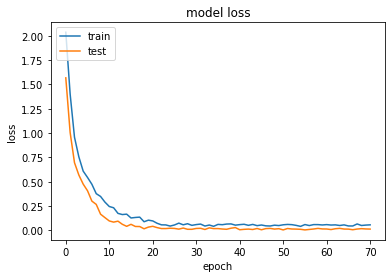

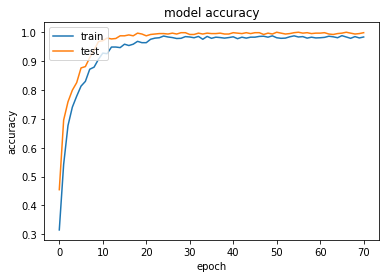

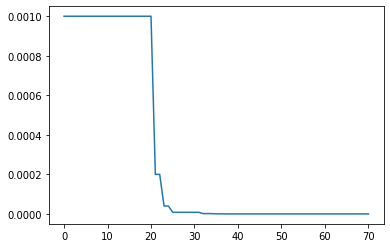

In [61]:
model = Sequential()
model.add(Input(shape=input_shape + (3,)))

model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(train_data.num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model4')

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140 (Conv2D)         (None, 100, 100, 32)      896       
                                                                 
 conv2d_141 (Conv2D)         (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_142 (Conv2D)         (None, 50, 50, 128)       73856     
                                                                 
 conv2d_143 (Conv2D)         (None, 50, 50, 128)       147584    
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 25, 25, 128)      0         
 g2D)                                                

48/48 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9408
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 20: accuracy did not improve from 0.95398
48/48 [==============================] - 4s 93ms/step - loss: 0.1551 - accuracy: 0.9408 - val_loss: 0.0513 - val_accuracy: 0.9768 - lr: 2.0000e-04
Epoch 21/20000
48/48 [==============================] - ETA: 0s - loss: 0.1082 - accuracy: 0.9632
Epoch 21: accuracy improved from 0.95398 to 0.96318, saving model to ./model5\epoch_021-acc_0.96318-valacc_0.99227.hdf5
48/48 [==============================] - 5s 99ms/step - loss: 0.1082 - accuracy: 0.9632 - val_loss: 0.0369 - val_accuracy: 0.9923 - lr: 4.0000e-05
Epoch 22/20000
48/48 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9625
Epoch 22: accuracy did not improve from 0.96318
48/48 [==============================] - 5s 95ms/step - loss: 0.1159 - accuracy: 0.9625 - val_loss: 0.0639 - val_accuracy: 0.9907 - 

Epoch 45/20000
48/48 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9533
Epoch 45: accuracy did not improve from 0.96713
48/48 [==============================] - 4s 93ms/step - loss: 0.1388 - accuracy: 0.9533 - val_loss: 0.0366 - val_accuracy: 0.9892 - lr: 4.0960e-12
Epoch 46/20000
48/48 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9474
Epoch 46: ReduceLROnPlateau reducing learning rate to 8.192000897078167e-13.

Epoch 46: accuracy did not improve from 0.96713
48/48 [==============================] - 4s 94ms/step - loss: 0.1478 - accuracy: 0.9474 - val_loss: 0.0485 - val_accuracy: 0.9876 - lr: 4.0960e-12
Epoch 47/20000
48/48 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9606
Epoch 47: accuracy did not improve from 0.96713
48/48 [==============================] - 4s 93ms/step - loss: 0.1152 - accuracy: 0.9606 - val_loss: 0.0400 - val_accuracy: 0.9876 - lr: 8.1920e-13
Epoch 48/20000
48/48 [=====================

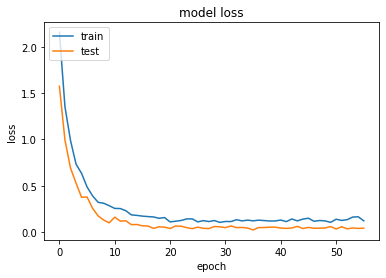

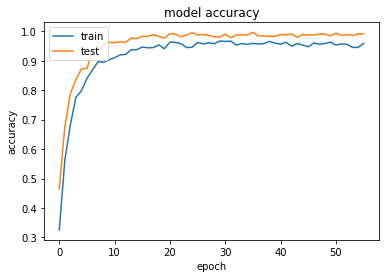

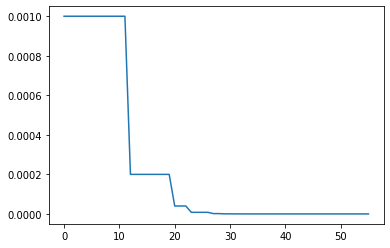

In [62]:
model = Sequential()
model.add(Input(shape=input_shape + (3,)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(train_data.num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_238 (Conv2D)            (None, 49, 49, 32)   864         ['input_19[0][0]']               
                                                                                                  
 batch_normalization_198 (Batch  (None, 49, 49, 32)  96          ['conv2d_238[0][0]']             
 Normalization)                                                                                   
                                                                                            

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_208 (Batch  (None, 10, 10, 96)  288         ['conv2d_248[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_209 (Batch  (None, 10, 10, 32)  96          ['conv2d_249[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 10, 10, 64)   0           ['batch_normalization_203[0][0]']
                                                                                                  
 activatio

 activation_220 (Activation)    (None, 10, 10, 64)   0           ['batch_normalization_220[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 10, 10, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_261 (Conv2D)            (None, 10, 10, 96)   55296       ['activation_220[0][0]']         
                                                                                                  
 batch_normalization_218 (Batch  (None, 10, 10, 48)  144         ['conv2d_258[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_221 (Batch  (None, 10, 10, 96)  288         ['conv2d_261[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 4, 4, 768)    0           ['activation_224[0][0]',         
                                                                  'activation_227[0][0]',         
                                                                  'max_pooling2d_42[0][0]']       
                                                                                                  
 conv2d_272 (Conv2D)            (None, 4, 4, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_232 (Batch  (None, 4, 4, 128)   384         ['conv2d_272[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 4, 4, 128)    0           ['batch_normalization_232[0][0]']
          

                                                                                                  
 batch_normalization_242 (Batch  (None, 4, 4, 160)   480         ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 4, 4, 160)    0           ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_283 (Conv2D)            (None, 4, 4, 160)    179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 4, 4, 160)   480         ['conv2d_283[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_293 (Conv2D)            (None, 4, 4, 160)    179200      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_253 (Batch  (None, 4, 4, 160)   480         ['conv2d_293[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 4, 4, 160)    0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_289 (Conv2D)            (None, 4, 4, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_29

                                                                                                  
 activation_263 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_263[0][0]']
                                                                                                  
 conv2d_299 (Conv2D)            (None, 4, 4, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_304 (Conv2D)            (None, 4, 4, 192)    258048      ['activation_263[0][0]']         
                                                                                                  
 batch_normalization_259 (Batch  (None, 4, 4, 192)   576         ['conv2d_299[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_312 (Conv2D)            (None, 4, 4, 192)    258048      ['activation_271[0][0]']         
                                                                                                  
 batch_normalization_268 (Batch  (None, 4, 4, 192)   576         ['conv2d_308[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_272 (Batch  (None, 4, 4, 192)   576         ['conv2d_312[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_268 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_268[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_276 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_276[0][0]']
                                                                                                  
 activation_277 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_277[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 activation_281 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_281[0][0]']
                                                                                                  
 batch_normalization_282 (Batch  (None, 1, 1, 192)   576         ['conv2d_322[0][0]']             
 Normaliza

                                                                                                  
 activation_290 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_290[0][0]']
                                                                                                  
 batch_normalization_291 (Batch  (None, 1, 1, 192)   576         ['conv2d_331[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_283 (Activation)    (None, 1, 1, 320)    0           ['batch_normalization_283[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_285[0][0]',         
                                                                  'activation_286[0][0]']         
          

Epoch 15/100
48/48 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9836
Epoch 15: accuracy did not improve from 0.98554
48/48 [==============================] - 5s 101ms/step - loss: 0.0598 - accuracy: 0.9836 - val_loss: 0.0465 - val_accuracy: 0.9845 - lr: 1.6000e-06
Epoch 16/100
48/48 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9809
Epoch 16: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 16: accuracy did not improve from 0.98554
48/48 [==============================] - 5s 101ms/step - loss: 0.0592 - accuracy: 0.9809 - val_loss: 0.0622 - val_accuracy: 0.9861 - lr: 1.6000e-06
Epoch 17/100
48/48 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9875
Epoch 17: accuracy improved from 0.98554 to 0.98751, saving model to ./model_inceptionV3_step1\epoch_017-acc_0.98751-valacc_0.98609.hdf5
48/48 [==============================] - 5s 108ms/step - loss: 0.0378 - accuracy: 0.9875 - val_loss: 0.04

48/48 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9849
Epoch 39: ReduceLROnPlateau reducing learning rate to 6.553600300244697e-15.

Epoch 39: accuracy did not improve from 0.98948
48/48 [==============================] - 5s 100ms/step - loss: 0.0540 - accuracy: 0.9849 - val_loss: 0.0526 - val_accuracy: 0.9845 - lr: 3.2768e-14
Epoch 40/100
48/48 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9836
Epoch 40: accuracy did not improve from 0.98948
48/48 [==============================] - 5s 101ms/step - loss: 0.0491 - accuracy: 0.9836 - val_loss: 0.0258 - val_accuracy: 0.9938 - lr: 6.5536e-15
Epoch 41/100
48/48 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9862
Epoch 41: ReduceLROnPlateau reducing learning rate to 1.3107200431082805e-15.

Epoch 41: accuracy did not improve from 0.98948
48/48 [==============================] - 5s 100ms/step - loss: 0.0442 - accuracy: 0.9862 - val_loss: 0.0449 - val_accuracy: 0.98

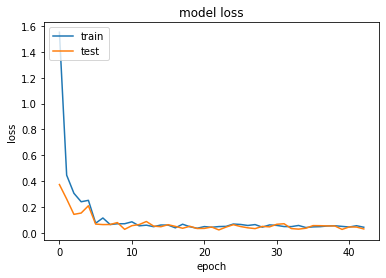

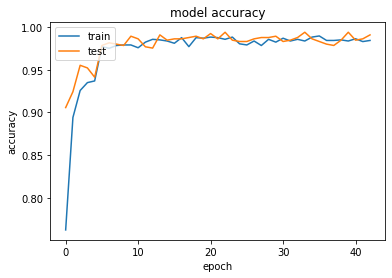

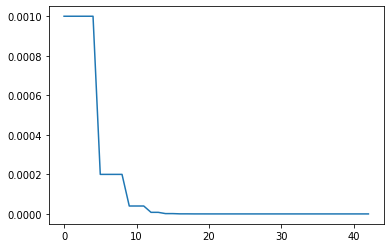

In [65]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

input_tensor = Input(shape=input_shape+(3,))

base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model_inceptionV3_step1', epochs=100)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_238 (Conv2D)            (None, 49, 49, 32)   864         ['input_19[0][0]']               
                                                                                                  
 batch_normalization_198 (Batch  (None, 49, 49, 32)  96          ['conv2d_238[0][0]']             
 Normalization)                                                                                   
                                                                                            

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_208 (Batch  (None, 10, 10, 96)  288         ['conv2d_248[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_209 (Batch  (None, 10, 10, 32)  96          ['conv2d_249[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 10, 10, 64)   0           ['batch_normalization_203[0][0]']
                                                                                                  
 activatio

 activation_220 (Activation)    (None, 10, 10, 64)   0           ['batch_normalization_220[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 10, 10, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_261 (Conv2D)            (None, 10, 10, 96)   55296       ['activation_220[0][0]']         
                                                                                                  
 batch_normalization_218 (Batch  (None, 10, 10, 48)  144         ['conv2d_258[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_221 (Batch  (None, 10, 10, 96)  288         ['conv2d_261[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 4, 4, 768)    0           ['activation_224[0][0]',         
                                                                  'activation_227[0][0]',         
                                                                  'max_pooling2d_42[0][0]']       
                                                                                                  
 conv2d_272 (Conv2D)            (None, 4, 4, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_232 (Batch  (None, 4, 4, 128)   384         ['conv2d_272[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 4, 4, 128)    0           ['batch_normalization_232[0][0]']
          

                                                                                                  
 batch_normalization_242 (Batch  (None, 4, 4, 160)   480         ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 4, 4, 160)    0           ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_283 (Conv2D)            (None, 4, 4, 160)    179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 4, 4, 160)   480         ['conv2d_283[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_293 (Conv2D)            (None, 4, 4, 160)    179200      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_253 (Batch  (None, 4, 4, 160)   480         ['conv2d_293[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 4, 4, 160)    0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_289 (Conv2D)            (None, 4, 4, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_29

                                                                                                  
 activation_263 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_263[0][0]']
                                                                                                  
 conv2d_299 (Conv2D)            (None, 4, 4, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_304 (Conv2D)            (None, 4, 4, 192)    258048      ['activation_263[0][0]']         
                                                                                                  
 batch_normalization_259 (Batch  (None, 4, 4, 192)   576         ['conv2d_299[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_312 (Conv2D)            (None, 4, 4, 192)    258048      ['activation_271[0][0]']         
                                                                                                  
 batch_normalization_268 (Batch  (None, 4, 4, 192)   576         ['conv2d_308[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_272 (Batch  (None, 4, 4, 192)   576         ['conv2d_312[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_268 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_268[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_276 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_276[0][0]']
                                                                                                  
 activation_277 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_277[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 activation_281 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_281[0][0]']
                                                                                                  
 batch_normalization_282 (Batch  (None, 1, 1, 192)   576         ['conv2d_322[0][0]']             
 Normaliza

                                                                                                  
 activation_290 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_290[0][0]']
                                                                                                  
 batch_normalization_291 (Batch  (None, 1, 1, 192)   576         ['conv2d_331[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_283 (Activation)    (None, 1, 1, 320)    0           ['batch_normalization_283[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_285[0][0]',         
                                                                  'activation_286[0][0]']         
          

Epoch 16/100
48/48 [==============================] - ETA: 0s - loss: 0.2466 - accuracy: 0.9356
Epoch 16: accuracy did not improve from 0.93820
48/48 [==============================] - 5s 103ms/step - loss: 0.2466 - accuracy: 0.9356 - val_loss: 0.1776 - val_accuracy: 0.9521 - lr: 1.2800e-09
Epoch 17/100
48/48 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9297
Epoch 17: ReduceLROnPlateau reducing learning rate to 2.55999976772614e-10.

Epoch 17: accuracy did not improve from 0.93820
48/48 [==============================] - 5s 102ms/step - loss: 0.2615 - accuracy: 0.9297 - val_loss: 0.1479 - val_accuracy: 0.9645 - lr: 1.2800e-09
Epoch 18/100
48/48 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9329
Epoch 18: accuracy did not improve from 0.93820
48/48 [==============================] - 5s 103ms/step - loss: 0.2437 - accuracy: 0.9329 - val_loss: 0.1751 - val_accuracy: 0.9660 - lr: 2.5600e-10
Epoch 19/100
48/48 [===========================

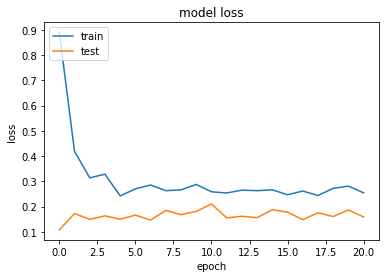

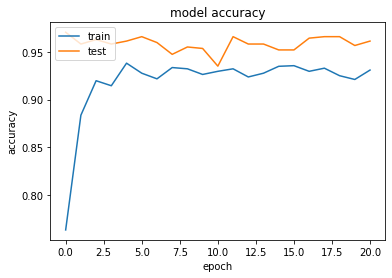

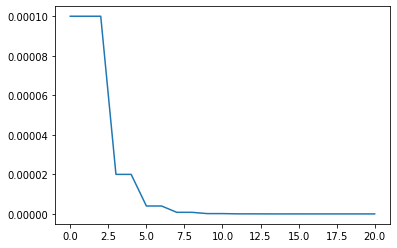

In [66]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model_inceptionV3_step2', epochs=100)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_238 (Conv2D)            (None, 49, 49, 32)   864         ['input_19[0][0]']               
                                                                                                  
 batch_normalization_198 (Batch  (None, 49, 49, 32)  96          ['conv2d_238[0][0]']             
 Normalization)                                                                                   
                                                                                            

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_208 (Batch  (None, 10, 10, 96)  288         ['conv2d_248[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_209 (Batch  (None, 10, 10, 32)  96          ['conv2d_249[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_203 (Activation)    (None, 10, 10, 64)   0           ['batch_normalization_203[0][0]']
                                                                                                  
 activatio

 activation_220 (Activation)    (None, 10, 10, 64)   0           ['batch_normalization_220[0][0]']
                                                                                                  
 conv2d_258 (Conv2D)            (None, 10, 10, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_261 (Conv2D)            (None, 10, 10, 96)   55296       ['activation_220[0][0]']         
                                                                                                  
 batch_normalization_218 (Batch  (None, 10, 10, 48)  144         ['conv2d_258[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_221 (Batch  (None, 10, 10, 96)  288         ['conv2d_261[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 4, 4, 768)    0           ['activation_224[0][0]',         
                                                                  'activation_227[0][0]',         
                                                                  'max_pooling2d_42[0][0]']       
                                                                                                  
 conv2d_272 (Conv2D)            (None, 4, 4, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_232 (Batch  (None, 4, 4, 128)   384         ['conv2d_272[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_232 (Activation)    (None, 4, 4, 128)    0           ['batch_normalization_232[0][0]']
          

                                                                                                  
 batch_normalization_242 (Batch  (None, 4, 4, 160)   480         ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_242 (Activation)    (None, 4, 4, 160)    0           ['batch_normalization_242[0][0]']
                                                                                                  
 conv2d_283 (Conv2D)            (None, 4, 4, 160)    179200      ['activation_242[0][0]']         
                                                                                                  
 batch_normalization_243 (Batch  (None, 4, 4, 160)   480         ['conv2d_283[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_293 (Conv2D)            (None, 4, 4, 160)    179200      ['activation_252[0][0]']         
                                                                                                  
 batch_normalization_253 (Batch  (None, 4, 4, 160)   480         ['conv2d_293[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_253 (Activation)    (None, 4, 4, 160)    0           ['batch_normalization_253[0][0]']
                                                                                                  
 conv2d_289 (Conv2D)            (None, 4, 4, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_29

                                                                                                  
 activation_263 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_263[0][0]']
                                                                                                  
 conv2d_299 (Conv2D)            (None, 4, 4, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_304 (Conv2D)            (None, 4, 4, 192)    258048      ['activation_263[0][0]']         
                                                                                                  
 batch_normalization_259 (Batch  (None, 4, 4, 192)   576         ['conv2d_299[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_312 (Conv2D)            (None, 4, 4, 192)    258048      ['activation_271[0][0]']         
                                                                                                  
 batch_normalization_268 (Batch  (None, 4, 4, 192)   576         ['conv2d_308[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_272 (Batch  (None, 4, 4, 192)   576         ['conv2d_312[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_268 (Activation)    (None, 4, 4, 192)    0           ['batch_normalization_268[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_276 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_276[0][0]']
                                                                                                  
 activation_277 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_277[0][0]']
                                                                                                  
 activation_280 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_280[0][0]']
                                                                                                  
 activation_281 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_281[0][0]']
                                                                                                  
 batch_normalization_282 (Batch  (None, 1, 1, 192)   576         ['conv2d_322[0][0]']             
 Normaliza

                                                                                                  
 activation_290 (Activation)    (None, 1, 1, 384)    0           ['batch_normalization_290[0][0]']
                                                                                                  
 batch_normalization_291 (Batch  (None, 1, 1, 192)   576         ['conv2d_331[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_283 (Activation)    (None, 1, 1, 320)    0           ['batch_normalization_283[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_285[0][0]',         
                                                                  'activation_286[0][0]']         
          

48/48 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9145
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.27999988386307e-10.

Epoch 16: accuracy did not improve from 0.92702
48/48 [==============================] - 5s 102ms/step - loss: 0.2779 - accuracy: 0.9145 - val_loss: 0.2458 - val_accuracy: 0.9243 - lr: 6.4000e-10
Epoch 17/20000
48/48 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.9099
Epoch 17: accuracy did not improve from 0.92702
48/48 [==============================] - 5s 101ms/step - loss: 0.3122 - accuracy: 0.9099 - val_loss: 0.1910 - val_accuracy: 0.9490 - lr: 1.2800e-10
Epoch 18/20000
48/48 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.9060
Epoch 18: ReduceLROnPlateau reducing learning rate to 2.559999712214989e-11.

Epoch 18: accuracy did not improve from 0.92702
48/48 [==============================] - 5s 101ms/step - loss: 0.3327 - accuracy: 0.9060 - val_loss: 0.2518 - val_accuracy: 0.

Epoch 41/20000
48/48 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8994
Epoch 41: ReduceLROnPlateau reducing learning rate to 1e-18.

Epoch 41: accuracy did not improve from 0.92702
48/48 [==============================] - 5s 100ms/step - loss: 0.3296 - accuracy: 0.8994 - val_loss: 0.1896 - val_accuracy: 0.9444 - lr: 2.6214e-18
Epoch 42/20000
48/48 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.9139
Epoch 42: accuracy did not improve from 0.92702
48/48 [==============================] - 5s 103ms/step - loss: 0.3297 - accuracy: 0.9139 - val_loss: 0.2295 - val_accuracy: 0.9258 - lr: 1.0000e-18
Epoch 43/20000
48/48 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.9172
Epoch 43: accuracy did not improve from 0.92702
48/48 [==============================] - 5s 101ms/step - loss: 0.2987 - accuracy: 0.9172 - val_loss: 0.2304 - val_accuracy: 0.9397 - lr: 1.0000e-18
Epoch 44/20000
48/48 [==============================] - 

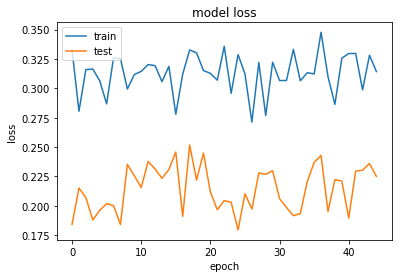

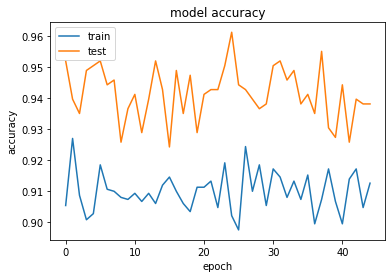

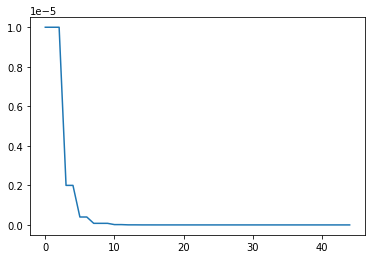

In [67]:
split_for_train = 230
for layer in model.layers[:split_for_train]:
   layer.trainable = False
for layer in model.layers[split_for_train:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model_inceptionV3_step3')


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 100, 100, 3)  0           ['input_20[0][0]']               
                                                                                                  
 stem_conv (Conv2D)             (None, 50, 50, 32)   864         ['rescaling_1[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 50, 50, 32)   128         ['stem_conv[0][0]']        

                                                                                                  
 block2b_project_conv (Conv2D)  (None, 25, 25, 64)   16384       ['block2b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 25, 25, 64)  256         ['block2b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_add (Add)              (None, 25, 25, 64)   0           ['block2b_project_bn[0][0]',     
                                                                  'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_e

 block2g_expand_activation (Act  (None, 25, 25, 256)  0          ['block2g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2g_project_conv (Conv2D)  (None, 25, 25, 64)   16384       ['block2g_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2g_project_bn (BatchNorma  (None, 25, 25, 64)  256         ['block2g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2g_add (Add)              (None, 25, 25, 64)   0           ['block2g_project_bn[0][0]',     
          

 ivation)                                                                                         
                                                                                                  
 block3e_project_conv (Conv2D)  (None, 13, 13, 96)   36864       ['block3e_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3e_project_bn (BatchNorma  (None, 13, 13, 96)  384         ['block3e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3e_add (Add)              (None, 13, 13, 96)   0           ['block3e_project_bn[0][0]',     
                                                                  'block3d_add[0][0]']            
          

                                                                                                  
 block4b_expand_activation (Act  (None, 7, 7, 768)   0           ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv2 (DepthwiseConv  (None, 7, 7, 768)   6912        ['block4b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 7, 7, 768)   3072        ['block4b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4b_a

                                                                                                  
 block4d_activation (Activation  (None, 7, 7, 768)   0           ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 768)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4d_se_squeeze[0][0]']     
                                                                                                  
 block4d_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4d_se_reshape[0][0]']     
          

 block4f_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4f_se_reshape[0][0]']     
                                                                                                  
 block4f_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4f_se_reduce[0][0]']      
                                                                                                  
 block4f_se_excite (Multiply)   (None, 7, 7, 768)    0           ['block4f_activation[0][0]',     
                                                                  'block4f_se_expand[0][0]']      
                                                                                                  
 block4f_project_conv (Conv2D)  (None, 7, 7, 192)    147456      ['block4f_se_excite[0][0]']      
                                                                                                  
 block4f_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block4f_project_conv[0][0]']   
 lization)

 block4h_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block4h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4h_add (Add)              (None, 7, 7, 192)    0           ['block4h_project_bn[0][0]',     
                                                                  'block4g_add[0][0]']            
                                                                                                  
 block4i_expand_conv (Conv2D)   (None, 7, 7, 768)    147456      ['block4h_add[0][0]']            
                                                                                                  
 block4i_expand_bn (BatchNormal  (None, 7, 7, 768)   3072        ['block4i_expand_conv[0][0]']    
 ization)                                                                                         
          

 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block5a_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block5a_dwconv2[0][0]']        
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 1344)        0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5c_se_reduce[0][0]']      
          

 block5e_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5e_se_reduce[0][0]']      
                                                                                                  
 block5e_se_excite (Multiply)   (None, 7, 7, 1344)   0           ['block5e_activation[0][0]',     
                                                                  'block5e_se_expand[0][0]']      
                                                                                                  
 block5e_project_conv (Conv2D)  (None, 7, 7, 224)    301056      ['block5e_se_excite[0][0]']      
                                                                                                  
 block5e_project_bn (BatchNorma  (None, 7, 7, 224)   896         ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_a

                                                                                                  
 block5g_add (Add)              (None, 7, 7, 224)    0           ['block5g_project_bn[0][0]',     
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 7, 7, 1344)   301056      ['block5g_add[0][0]']            
                                                                                                  
 block5h_expand_bn (BatchNormal  (None, 7, 7, 1344)  5376        ['block5h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5h_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5h_expand_bn[0][0]']      
 ivation) 

 block5j_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5j_dwconv2 (DepthwiseConv  (None, 7, 7, 1344)  12096       ['block5j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5j_bn (BatchNormalization  (None, 7, 7, 1344)  5376        ['block5j_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5j_activation (Activation  (None, 7, 7, 1344)  0           ['block5j_bn[0][0]']             
 )        

 block5l_activation (Activation  (None, 7, 7, 1344)  0           ['block5l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5l_se_squeeze (GlobalAver  (None, 1344)        0           ['block5l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5l_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5l_se_squeeze[0][0]']     
                                                                                                  
 block5l_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5l_se_reshape[0][0]']     
                                                                                                  
 block5l_s

                                                                                                  
 block5n_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5n_se_reduce[0][0]']      
                                                                                                  
 block5n_se_excite (Multiply)   (None, 7, 7, 1344)   0           ['block5n_activation[0][0]',     
                                                                  'block5n_se_expand[0][0]']      
                                                                                                  
 block5n_project_conv (Conv2D)  (None, 7, 7, 224)    301056      ['block5n_se_excite[0][0]']      
                                                                                                  
 block5n_project_bn (BatchNorma  (None, 7, 7, 224)   896         ['block5n_project_conv[0][0]']   
 lization)                                                                                        
          

 lization)                                                                                        
                                                                                                  
 block5p_add (Add)              (None, 7, 7, 224)    0           ['block5p_project_bn[0][0]',     
                                                                  'block5o_add[0][0]']            
                                                                                                  
 block5q_expand_conv (Conv2D)   (None, 7, 7, 1344)   301056      ['block5p_add[0][0]']            
                                                                                                  
 block5q_expand_bn (BatchNormal  (None, 7, 7, 1344)  5376        ['block5q_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5q_e

                                                                                                  
 block5s_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5s_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5s_dwconv2 (DepthwiseConv  (None, 7, 7, 1344)  12096       ['block5s_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5s_bn (BatchNormalization  (None, 7, 7, 1344)  5376        ['block5s_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5s_a

                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 2304)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_s

                                                                                                  
 block6d_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_add (Add)              (None, 4, 4, 384)    0           ['block6d_project_bn[0][0]',     
          

 block6f_add (Add)              (None, 4, 4, 384)    0           ['block6f_project_bn[0][0]',     
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6g_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6g_expand_bn[0][0]']      
 ivation)                                                                                         
          

 ivation)                                                                                         
                                                                                                  
 block6i_dwconv2 (DepthwiseConv  (None, 4, 4, 2304)  20736       ['block6i_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6i_bn (BatchNormalization  (None, 4, 4, 2304)  9216        ['block6i_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6i_activation (Activation  (None, 4, 4, 2304)  0           ['block6i_bn[0][0]']             
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 2304)        0           ['block6k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6k_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6k_se_squeeze[0][0]']     
                                                                                                  
 block6k_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6k_se_reshape[0][0]']     
                                                                                                  
 block6k_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6k_se_reduce[0][0]']      
          

 block6m_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6m_se_reduce[0][0]']      
                                                                                                  
 block6m_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6m_activation[0][0]',     
                                                                  'block6m_se_expand[0][0]']      
                                                                                                  
 block6m_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6m_se_excite[0][0]']      
                                                                                                  
 block6m_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6m_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6m_a

                                                                                                  
 block6o_add (Add)              (None, 4, 4, 384)    0           ['block6o_project_bn[0][0]',     
                                                                  'block6n_add[0][0]']            
                                                                                                  
 block6p_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6o_add[0][0]']            
                                                                                                  
 block6p_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6p_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6p_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6p_expand_bn[0][0]']      
 ivation) 

 block6r_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6r_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6r_dwconv2 (DepthwiseConv  (None, 4, 4, 2304)  20736       ['block6r_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6r_bn (BatchNormalization  (None, 4, 4, 2304)  9216        ['block6r_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6r_activation (Activation  (None, 4, 4, 2304)  0           ['block6r_bn[0][0]']             
 )        

 block6t_activation (Activation  (None, 4, 4, 2304)  0           ['block6t_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6t_se_squeeze (GlobalAver  (None, 2304)        0           ['block6t_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6t_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6t_se_squeeze[0][0]']     
                                                                                                  
 block6t_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6t_se_reshape[0][0]']     
                                                                                                  
 block6t_s

                                                                                                  
 block6v_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6v_se_reduce[0][0]']      
                                                                                                  
 block6v_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6v_activation[0][0]',     
                                                                  'block6v_se_expand[0][0]']      
                                                                                                  
 block6v_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6v_se_excite[0][0]']      
                                                                                                  
 block6v_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6v_project_conv[0][0]']   
 lization)                                                                                        
          

 lization)                                                                                        
                                                                                                  
 block6x_add (Add)              (None, 4, 4, 384)    0           ['block6x_project_bn[0][0]',     
                                                                  'block6w_add[0][0]']            
                                                                                                  
 block6y_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6x_add[0][0]']            
                                                                                                  
 block6y_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6y_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6y_e

                                                                                                  
 block7b_dwconv2 (DepthwiseConv  (None, 4, 4, 3840)  34560       ['block7b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block7b_bn (BatchNormalization  (None, 4, 4, 3840)  15360       ['block7b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block7b_activation (Activation  (None, 4, 4, 3840)  0           ['block7b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7b_s

                                                                                                  
 block7d_se_squeeze (GlobalAver  (None, 3840)        0           ['block7d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7d_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7d_se_squeeze[0][0]']     
                                                                                                  
 block7d_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7d_se_reshape[0][0]']     
                                                                                                  
 block7d_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7d_se_reduce[0][0]']      
                                                                                                  
 block7d_s

                                                                                                  
 block7f_se_excite (Multiply)   (None, 4, 4, 3840)   0           ['block7f_activation[0][0]',     
                                                                  'block7f_se_expand[0][0]']      
                                                                                                  
 block7f_project_conv (Conv2D)  (None, 4, 4, 640)    2457600     ['block7f_se_excite[0][0]']      
                                                                                                  
 block7f_project_bn (BatchNorma  (None, 4, 4, 640)   2560        ['block7f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7f_add (Add)              (None, 4, 4, 640)    0           ['block7f_project_bn[0][0]',     
          

Epoch 7/100
48/48 [==============================] - ETA: 0s - loss: 1.3507 - accuracy: 0.5227
Epoch 7: accuracy did not improve from 0.85000
48/48 [==============================] - 8s 169ms/step - loss: 1.3507 - accuracy: 0.5227 - val_loss: 1.2360 - val_accuracy: 0.6059 - lr: 0.0010
Epoch 8/100
48/48 [==============================] - ETA: 0s - loss: 1.3048 - accuracy: 0.5371
Epoch 8: accuracy did not improve from 0.85000
48/48 [==============================] - 8s 164ms/step - loss: 1.3048 - accuracy: 0.5371 - val_loss: 1.2989 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 9/100
48/48 [==============================] - ETA: 0s - loss: 1.2464 - accuracy: 0.5575
Epoch 9: accuracy did not improve from 0.85000
48/48 [==============================] - 8s 175ms/step - loss: 1.2464 - accuracy: 0.5575 - val_loss: 1.2131 - val_accuracy: 0.5951 - lr: 0.0010
Epoch 10/100
48/48 [==============================] - ETA: 0s - loss: 1.2644 - accuracy: 0.5641
Epoch 10: accuracy did not improve from 0.8500

Epoch 34/100
48/48 [==============================] - ETA: 0s - loss: 0.8019 - accuracy: 0.7390
Epoch 34: accuracy did not improve from 0.85000
48/48 [==============================] - 8s 164ms/step - loss: 0.8019 - accuracy: 0.7390 - val_loss: 0.8056 - val_accuracy: 0.7604 - lr: 3.2000e-07
Epoch 35/100
48/48 [==============================] - ETA: 0s - loss: 0.8123 - accuracy: 0.7423
Epoch 35: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.

Epoch 35: accuracy did not improve from 0.85000
48/48 [==============================] - 8s 171ms/step - loss: 0.8123 - accuracy: 0.7423 - val_loss: 0.8682 - val_accuracy: 0.7141 - lr: 3.2000e-07
Epoch 36/100
48/48 [==============================] - ETA: 0s - loss: 0.8282 - accuracy: 0.7383
Epoch 36: accuracy did not improve from 0.85000
48/48 [==============================] - 8s 167ms/step - loss: 0.8282 - accuracy: 0.7383 - val_loss: 0.8435 - val_accuracy: 0.7280 - lr: 6.4000e-08
Epoch 37/100
48/48 [==========================

Epoch 58: early stopping


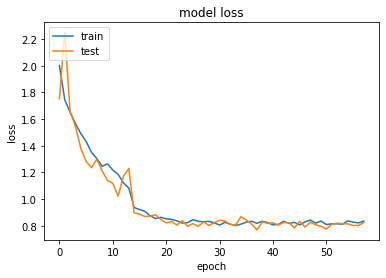

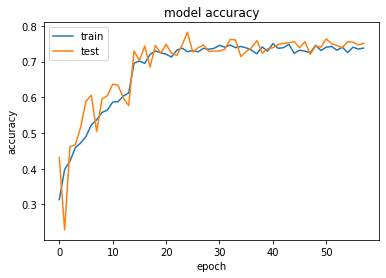

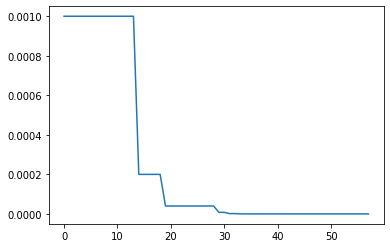

In [68]:
from keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

input_tensor = Input(shape=input_shape+(3,))

base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


do_fit(model, train_data, validation_data, 'model_EfficientNetV2L_step1', epochs=100)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 100, 100, 3)  0           ['input_20[0][0]']               
                                                                                                  
 stem_conv (Conv2D)             (None, 50, 50, 32)   864         ['rescaling_1[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 50, 50, 32)   128         ['stem_conv[0][0]']        

                                                                                                  
 block2b_project_conv (Conv2D)  (None, 25, 25, 64)   16384       ['block2b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 25, 25, 64)  256         ['block2b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_add (Add)              (None, 25, 25, 64)   0           ['block2b_project_bn[0][0]',     
                                                                  'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_e

 block2g_expand_activation (Act  (None, 25, 25, 256)  0          ['block2g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2g_project_conv (Conv2D)  (None, 25, 25, 64)   16384       ['block2g_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2g_project_bn (BatchNorma  (None, 25, 25, 64)  256         ['block2g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2g_add (Add)              (None, 25, 25, 64)   0           ['block2g_project_bn[0][0]',     
          

 ivation)                                                                                         
                                                                                                  
 block3e_project_conv (Conv2D)  (None, 13, 13, 96)   36864       ['block3e_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3e_project_bn (BatchNorma  (None, 13, 13, 96)  384         ['block3e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3e_add (Add)              (None, 13, 13, 96)   0           ['block3e_project_bn[0][0]',     
                                                                  'block3d_add[0][0]']            
          

                                                                                                  
 block4b_expand_activation (Act  (None, 7, 7, 768)   0           ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv2 (DepthwiseConv  (None, 7, 7, 768)   6912        ['block4b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 7, 7, 768)   3072        ['block4b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4b_a

                                                                                                  
 block4d_activation (Activation  (None, 7, 7, 768)   0           ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 768)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4d_se_squeeze[0][0]']     
                                                                                                  
 block4d_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4d_se_reshape[0][0]']     
          

 block4f_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4f_se_reshape[0][0]']     
                                                                                                  
 block4f_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4f_se_reduce[0][0]']      
                                                                                                  
 block4f_se_excite (Multiply)   (None, 7, 7, 768)    0           ['block4f_activation[0][0]',     
                                                                  'block4f_se_expand[0][0]']      
                                                                                                  
 block4f_project_conv (Conv2D)  (None, 7, 7, 192)    147456      ['block4f_se_excite[0][0]']      
                                                                                                  
 block4f_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block4f_project_conv[0][0]']   
 lization)

 block4h_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block4h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4h_add (Add)              (None, 7, 7, 192)    0           ['block4h_project_bn[0][0]',     
                                                                  'block4g_add[0][0]']            
                                                                                                  
 block4i_expand_conv (Conv2D)   (None, 7, 7, 768)    147456      ['block4h_add[0][0]']            
                                                                                                  
 block4i_expand_bn (BatchNormal  (None, 7, 7, 768)   3072        ['block4i_expand_conv[0][0]']    
 ization)                                                                                         
          

 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block5a_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block5a_dwconv2[0][0]']        
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 1344)        0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5c_se_reduce[0][0]']      
          

 block5e_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5e_se_reduce[0][0]']      
                                                                                                  
 block5e_se_excite (Multiply)   (None, 7, 7, 1344)   0           ['block5e_activation[0][0]',     
                                                                  'block5e_se_expand[0][0]']      
                                                                                                  
 block5e_project_conv (Conv2D)  (None, 7, 7, 224)    301056      ['block5e_se_excite[0][0]']      
                                                                                                  
 block5e_project_bn (BatchNorma  (None, 7, 7, 224)   896         ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_a

                                                                                                  
 block5g_add (Add)              (None, 7, 7, 224)    0           ['block5g_project_bn[0][0]',     
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 7, 7, 1344)   301056      ['block5g_add[0][0]']            
                                                                                                  
 block5h_expand_bn (BatchNormal  (None, 7, 7, 1344)  5376        ['block5h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5h_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5h_expand_bn[0][0]']      
 ivation) 

 block5j_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5j_dwconv2 (DepthwiseConv  (None, 7, 7, 1344)  12096       ['block5j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5j_bn (BatchNormalization  (None, 7, 7, 1344)  5376        ['block5j_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5j_activation (Activation  (None, 7, 7, 1344)  0           ['block5j_bn[0][0]']             
 )        

 block5l_activation (Activation  (None, 7, 7, 1344)  0           ['block5l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5l_se_squeeze (GlobalAver  (None, 1344)        0           ['block5l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5l_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5l_se_squeeze[0][0]']     
                                                                                                  
 block5l_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5l_se_reshape[0][0]']     
                                                                                                  
 block5l_s

                                                                                                  
 block5n_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5n_se_reduce[0][0]']      
                                                                                                  
 block5n_se_excite (Multiply)   (None, 7, 7, 1344)   0           ['block5n_activation[0][0]',     
                                                                  'block5n_se_expand[0][0]']      
                                                                                                  
 block5n_project_conv (Conv2D)  (None, 7, 7, 224)    301056      ['block5n_se_excite[0][0]']      
                                                                                                  
 block5n_project_bn (BatchNorma  (None, 7, 7, 224)   896         ['block5n_project_conv[0][0]']   
 lization)                                                                                        
          

 lization)                                                                                        
                                                                                                  
 block5p_add (Add)              (None, 7, 7, 224)    0           ['block5p_project_bn[0][0]',     
                                                                  'block5o_add[0][0]']            
                                                                                                  
 block5q_expand_conv (Conv2D)   (None, 7, 7, 1344)   301056      ['block5p_add[0][0]']            
                                                                                                  
 block5q_expand_bn (BatchNormal  (None, 7, 7, 1344)  5376        ['block5q_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5q_e

                                                                                                  
 block5s_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5s_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5s_dwconv2 (DepthwiseConv  (None, 7, 7, 1344)  12096       ['block5s_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5s_bn (BatchNormalization  (None, 7, 7, 1344)  5376        ['block5s_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5s_a

                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 2304)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_s

                                                                                                  
 block6d_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_add (Add)              (None, 4, 4, 384)    0           ['block6d_project_bn[0][0]',     
          

 block6f_add (Add)              (None, 4, 4, 384)    0           ['block6f_project_bn[0][0]',     
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6g_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6g_expand_bn[0][0]']      
 ivation)                                                                                         
          

 ivation)                                                                                         
                                                                                                  
 block6i_dwconv2 (DepthwiseConv  (None, 4, 4, 2304)  20736       ['block6i_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6i_bn (BatchNormalization  (None, 4, 4, 2304)  9216        ['block6i_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6i_activation (Activation  (None, 4, 4, 2304)  0           ['block6i_bn[0][0]']             
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 2304)        0           ['block6k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6k_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6k_se_squeeze[0][0]']     
                                                                                                  
 block6k_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6k_se_reshape[0][0]']     
                                                                                                  
 block6k_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6k_se_reduce[0][0]']      
          

 block6m_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6m_se_reduce[0][0]']      
                                                                                                  
 block6m_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6m_activation[0][0]',     
                                                                  'block6m_se_expand[0][0]']      
                                                                                                  
 block6m_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6m_se_excite[0][0]']      
                                                                                                  
 block6m_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6m_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6m_a

                                                                                                  
 block6o_add (Add)              (None, 4, 4, 384)    0           ['block6o_project_bn[0][0]',     
                                                                  'block6n_add[0][0]']            
                                                                                                  
 block6p_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6o_add[0][0]']            
                                                                                                  
 block6p_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6p_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6p_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6p_expand_bn[0][0]']      
 ivation) 

 block6r_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6r_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6r_dwconv2 (DepthwiseConv  (None, 4, 4, 2304)  20736       ['block6r_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6r_bn (BatchNormalization  (None, 4, 4, 2304)  9216        ['block6r_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6r_activation (Activation  (None, 4, 4, 2304)  0           ['block6r_bn[0][0]']             
 )        

 block6t_activation (Activation  (None, 4, 4, 2304)  0           ['block6t_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6t_se_squeeze (GlobalAver  (None, 2304)        0           ['block6t_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6t_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6t_se_squeeze[0][0]']     
                                                                                                  
 block6t_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6t_se_reshape[0][0]']     
                                                                                                  
 block6t_s

                                                                                                  
 block6v_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6v_se_reduce[0][0]']      
                                                                                                  
 block6v_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6v_activation[0][0]',     
                                                                  'block6v_se_expand[0][0]']      
                                                                                                  
 block6v_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6v_se_excite[0][0]']      
                                                                                                  
 block6v_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6v_project_conv[0][0]']   
 lization)                                                                                        
          

 lization)                                                                                        
                                                                                                  
 block6x_add (Add)              (None, 4, 4, 384)    0           ['block6x_project_bn[0][0]',     
                                                                  'block6w_add[0][0]']            
                                                                                                  
 block6y_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6x_add[0][0]']            
                                                                                                  
 block6y_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6y_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6y_e

                                                                                                  
 block7b_dwconv2 (DepthwiseConv  (None, 4, 4, 3840)  34560       ['block7b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block7b_bn (BatchNormalization  (None, 4, 4, 3840)  15360       ['block7b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block7b_activation (Activation  (None, 4, 4, 3840)  0           ['block7b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7b_s

                                                                                                  
 block7d_se_squeeze (GlobalAver  (None, 3840)        0           ['block7d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7d_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7d_se_squeeze[0][0]']     
                                                                                                  
 block7d_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7d_se_reshape[0][0]']     
                                                                                                  
 block7d_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7d_se_reduce[0][0]']      
                                                                                                  
 block7d_s

                                                                                                  
 block7f_se_excite (Multiply)   (None, 4, 4, 3840)   0           ['block7f_activation[0][0]',     
                                                                  'block7f_se_expand[0][0]']      
                                                                                                  
 block7f_project_conv (Conv2D)  (None, 4, 4, 640)    2457600     ['block7f_se_excite[0][0]']      
                                                                                                  
 block7f_project_bn (BatchNorma  (None, 4, 4, 640)   2560        ['block7f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7f_add (Add)              (None, 4, 4, 640)    0           ['block7f_project_bn[0][0]',     
          

48/48 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8981
Epoch 6: accuracy improved from 0.87837 to 0.89809, saving model to ./model_EfficientNetV2L_step2\epoch_006-acc_0.89809-valacc_0.91499.hdf5
48/48 [==============================] - 13s 269ms/step - loss: 0.3332 - accuracy: 0.8981 - val_loss: 0.2765 - val_accuracy: 0.9150 - lr: 1.0000e-04
Epoch 7/100
48/48 [==============================] - ETA: 0s - loss: 0.2924 - accuracy: 0.9066
Epoch 7: accuracy improved from 0.89809 to 0.90664, saving model to ./model_EfficientNetV2L_step2\epoch_007-acc_0.90664-valacc_0.93972.hdf5
48/48 [==============================] - 13s 269ms/step - loss: 0.2924 - accuracy: 0.9066 - val_loss: 0.2137 - val_accuracy: 0.9397 - lr: 1.0000e-04
Epoch 8/100
48/48 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.9093
Epoch 8: accuracy improved from 0.90664 to 0.90927, saving model to ./model_EfficientNetV2L_step2\epoch_008-acc_0.90927-valacc_0.92117.hdf5
48/48 [==

Epoch 30/100
48/48 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9408
Epoch 30: accuracy did not improve from 0.95201
48/48 [==============================] - 11s 233ms/step - loss: 0.2007 - accuracy: 0.9408 - val_loss: 0.1748 - val_accuracy: 0.9474 - lr: 3.2000e-08
Epoch 31/100
48/48 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9375
Epoch 31: ReduceLROnPlateau reducing learning rate to 6.399999818995639e-09.

Epoch 31: accuracy did not improve from 0.95201
48/48 [==============================] - 11s 231ms/step - loss: 0.1965 - accuracy: 0.9375 - val_loss: 0.1573 - val_accuracy: 0.9567 - lr: 3.2000e-08
Epoch 32/100
48/48 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9402
Epoch 32: accuracy did not improve from 0.95201
48/48 [==============================] - 11s 229ms/step - loss: 0.2069 - accuracy: 0.9402 - val_loss: 0.1555 - val_accuracy: 0.9490 - lr: 6.4000e-09
Epoch 33/100
48/48 [=======================

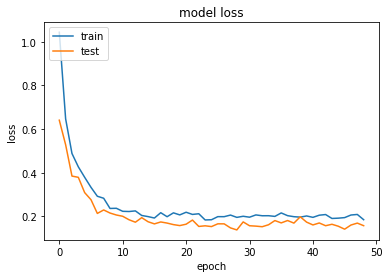

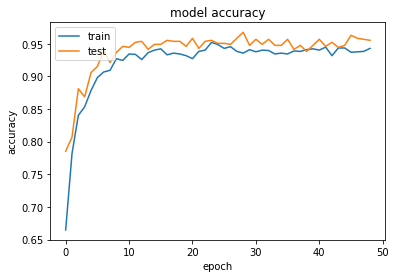

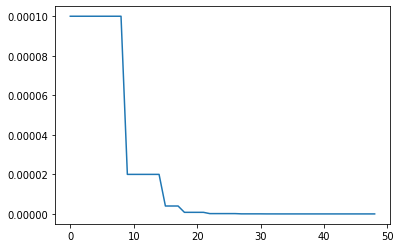

In [69]:
split_for_train = (len(base_model.layers) // 7) * 6  # 1/7th trainable.
for layer in model.layers[:split_for_train]:
   layer.trainable = False
for layer in model.layers[split_for_train:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

do_fit(model, train_data, validation_data, 'model_EfficientNetV2L_step2', epochs=100)

In [ ]:
split_for_train = (len(base_model.layers) // 7) * 5  # 2/7th trainable.
for layer in model.layers[:split_for_train]:
   layer.trainable = False
for layer in model.layers[split_for_train:]:
   layer.trainable = True

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

do_fit(model, train_data, validation_data, 'model_EfficientNetV2L_step3')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 100, 100, 3)  0           ['input_20[0][0]']               
                                                                                                  
 stem_conv (Conv2D)             (None, 50, 50, 32)   864         ['rescaling_1[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 50, 50, 32)   128         ['stem_conv[0][0]']        

                                                                                                  
 block2b_project_conv (Conv2D)  (None, 25, 25, 64)   16384       ['block2b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 25, 25, 64)  256         ['block2b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_add (Add)              (None, 25, 25, 64)   0           ['block2b_project_bn[0][0]',     
                                                                  'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_e

 block2g_expand_activation (Act  (None, 25, 25, 256)  0          ['block2g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2g_project_conv (Conv2D)  (None, 25, 25, 64)   16384       ['block2g_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2g_project_bn (BatchNorma  (None, 25, 25, 64)  256         ['block2g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2g_add (Add)              (None, 25, 25, 64)   0           ['block2g_project_bn[0][0]',     
          

 ivation)                                                                                         
                                                                                                  
 block3e_project_conv (Conv2D)  (None, 13, 13, 96)   36864       ['block3e_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3e_project_bn (BatchNorma  (None, 13, 13, 96)  384         ['block3e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3e_add (Add)              (None, 13, 13, 96)   0           ['block3e_project_bn[0][0]',     
                                                                  'block3d_add[0][0]']            
          

                                                                                                  
 block4b_expand_activation (Act  (None, 7, 7, 768)   0           ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv2 (DepthwiseConv  (None, 7, 7, 768)   6912        ['block4b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 7, 7, 768)   3072        ['block4b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4b_a

                                                                                                  
 block4d_activation (Activation  (None, 7, 7, 768)   0           ['block4d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4d_se_squeeze (GlobalAver  (None, 768)         0           ['block4d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4d_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4d_se_squeeze[0][0]']     
                                                                                                  
 block4d_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4d_se_reshape[0][0]']     
          

 block4f_se_reduce (Conv2D)     (None, 1, 1, 48)     36912       ['block4f_se_reshape[0][0]']     
                                                                                                  
 block4f_se_expand (Conv2D)     (None, 1, 1, 768)    37632       ['block4f_se_reduce[0][0]']      
                                                                                                  
 block4f_se_excite (Multiply)   (None, 7, 7, 768)    0           ['block4f_activation[0][0]',     
                                                                  'block4f_se_expand[0][0]']      
                                                                                                  
 block4f_project_conv (Conv2D)  (None, 7, 7, 192)    147456      ['block4f_se_excite[0][0]']      
                                                                                                  
 block4f_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block4f_project_conv[0][0]']   
 lization)

 block4h_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block4h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4h_add (Add)              (None, 7, 7, 192)    0           ['block4h_project_bn[0][0]',     
                                                                  'block4g_add[0][0]']            
                                                                                                  
 block4i_expand_conv (Conv2D)   (None, 7, 7, 768)    147456      ['block4h_add[0][0]']            
                                                                                                  
 block4i_expand_bn (BatchNormal  (None, 7, 7, 768)   3072        ['block4i_expand_conv[0][0]']    
 ization)                                                                                         
          

 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block5a_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block5a_dwconv2[0][0]']        
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 1344)        0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5c_se_reduce[0][0]']      
          

 block5e_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5e_se_reduce[0][0]']      
                                                                                                  
 block5e_se_excite (Multiply)   (None, 7, 7, 1344)   0           ['block5e_activation[0][0]',     
                                                                  'block5e_se_expand[0][0]']      
                                                                                                  
 block5e_project_conv (Conv2D)  (None, 7, 7, 224)    301056      ['block5e_se_excite[0][0]']      
                                                                                                  
 block5e_project_bn (BatchNorma  (None, 7, 7, 224)   896         ['block5e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5e_a

                                                                                                  
 block5g_add (Add)              (None, 7, 7, 224)    0           ['block5g_project_bn[0][0]',     
                                                                  'block5f_add[0][0]']            
                                                                                                  
 block5h_expand_conv (Conv2D)   (None, 7, 7, 1344)   301056      ['block5g_add[0][0]']            
                                                                                                  
 block5h_expand_bn (BatchNormal  (None, 7, 7, 1344)  5376        ['block5h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5h_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5h_expand_bn[0][0]']      
 ivation) 

 block5j_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5j_dwconv2 (DepthwiseConv  (None, 7, 7, 1344)  12096       ['block5j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5j_bn (BatchNormalization  (None, 7, 7, 1344)  5376        ['block5j_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5j_activation (Activation  (None, 7, 7, 1344)  0           ['block5j_bn[0][0]']             
 )        

 block5l_activation (Activation  (None, 7, 7, 1344)  0           ['block5l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5l_se_squeeze (GlobalAver  (None, 1344)        0           ['block5l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5l_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5l_se_squeeze[0][0]']     
                                                                                                  
 block5l_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5l_se_reshape[0][0]']     
                                                                                                  
 block5l_s

                                                                                                  
 block5n_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5n_se_reduce[0][0]']      
                                                                                                  
 block5n_se_excite (Multiply)   (None, 7, 7, 1344)   0           ['block5n_activation[0][0]',     
                                                                  'block5n_se_expand[0][0]']      
                                                                                                  
 block5n_project_conv (Conv2D)  (None, 7, 7, 224)    301056      ['block5n_se_excite[0][0]']      
                                                                                                  
 block5n_project_bn (BatchNorma  (None, 7, 7, 224)   896         ['block5n_project_conv[0][0]']   
 lization)                                                                                        
          

 lization)                                                                                        
                                                                                                  
 block5p_add (Add)              (None, 7, 7, 224)    0           ['block5p_project_bn[0][0]',     
                                                                  'block5o_add[0][0]']            
                                                                                                  
 block5q_expand_conv (Conv2D)   (None, 7, 7, 1344)   301056      ['block5p_add[0][0]']            
                                                                                                  
 block5q_expand_bn (BatchNormal  (None, 7, 7, 1344)  5376        ['block5q_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5q_e

                                                                                                  
 block5s_expand_activation (Act  (None, 7, 7, 1344)  0           ['block5s_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5s_dwconv2 (DepthwiseConv  (None, 7, 7, 1344)  12096       ['block5s_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5s_bn (BatchNormalization  (None, 7, 7, 1344)  5376        ['block5s_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5s_a

                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 2304)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_s

                                                                                                  
 block6d_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_add (Add)              (None, 4, 4, 384)    0           ['block6d_project_bn[0][0]',     
          

 block6f_add (Add)              (None, 4, 4, 384)    0           ['block6f_project_bn[0][0]',     
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6g_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6g_expand_bn[0][0]']      
 ivation)                                                                                         
          

 ivation)                                                                                         
                                                                                                  
 block6i_dwconv2 (DepthwiseConv  (None, 4, 4, 2304)  20736       ['block6i_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6i_bn (BatchNormalization  (None, 4, 4, 2304)  9216        ['block6i_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6i_activation (Activation  (None, 4, 4, 2304)  0           ['block6i_bn[0][0]']             
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 2304)        0           ['block6k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6k_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6k_se_squeeze[0][0]']     
                                                                                                  
 block6k_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6k_se_reshape[0][0]']     
                                                                                                  
 block6k_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6k_se_reduce[0][0]']      
          

 block6m_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6m_se_reduce[0][0]']      
                                                                                                  
 block6m_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6m_activation[0][0]',     
                                                                  'block6m_se_expand[0][0]']      
                                                                                                  
 block6m_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6m_se_excite[0][0]']      
                                                                                                  
 block6m_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6m_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6m_a

                                                                                                  
 block6o_add (Add)              (None, 4, 4, 384)    0           ['block6o_project_bn[0][0]',     
                                                                  'block6n_add[0][0]']            
                                                                                                  
 block6p_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6o_add[0][0]']            
                                                                                                  
 block6p_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6p_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6p_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6p_expand_bn[0][0]']      
 ivation) 

 block6r_expand_activation (Act  (None, 4, 4, 2304)  0           ['block6r_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6r_dwconv2 (DepthwiseConv  (None, 4, 4, 2304)  20736       ['block6r_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6r_bn (BatchNormalization  (None, 4, 4, 2304)  9216        ['block6r_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6r_activation (Activation  (None, 4, 4, 2304)  0           ['block6r_bn[0][0]']             
 )        

 block6t_activation (Activation  (None, 4, 4, 2304)  0           ['block6t_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6t_se_squeeze (GlobalAver  (None, 2304)        0           ['block6t_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6t_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block6t_se_squeeze[0][0]']     
                                                                                                  
 block6t_se_reduce (Conv2D)     (None, 1, 1, 96)     221280      ['block6t_se_reshape[0][0]']     
                                                                                                  
 block6t_s

                                                                                                  
 block6v_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6v_se_reduce[0][0]']      
                                                                                                  
 block6v_se_excite (Multiply)   (None, 4, 4, 2304)   0           ['block6v_activation[0][0]',     
                                                                  'block6v_se_expand[0][0]']      
                                                                                                  
 block6v_project_conv (Conv2D)  (None, 4, 4, 384)    884736      ['block6v_se_excite[0][0]']      
                                                                                                  
 block6v_project_bn (BatchNorma  (None, 4, 4, 384)   1536        ['block6v_project_conv[0][0]']   
 lization)                                                                                        
          

 lization)                                                                                        
                                                                                                  
 block6x_add (Add)              (None, 4, 4, 384)    0           ['block6x_project_bn[0][0]',     
                                                                  'block6w_add[0][0]']            
                                                                                                  
 block6y_expand_conv (Conv2D)   (None, 4, 4, 2304)   884736      ['block6x_add[0][0]']            
                                                                                                  
 block6y_expand_bn (BatchNormal  (None, 4, 4, 2304)  9216        ['block6y_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6y_e

                                                                                                  
 block7b_dwconv2 (DepthwiseConv  (None, 4, 4, 3840)  34560       ['block7b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block7b_bn (BatchNormalization  (None, 4, 4, 3840)  15360       ['block7b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block7b_activation (Activation  (None, 4, 4, 3840)  0           ['block7b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7b_s

                                                                                                  
 block7d_se_squeeze (GlobalAver  (None, 3840)        0           ['block7d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7d_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7d_se_squeeze[0][0]']     
                                                                                                  
 block7d_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7d_se_reshape[0][0]']     
                                                                                                  
 block7d_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7d_se_reduce[0][0]']      
                                                                                                  
 block7d_s

                                                                                                  
 block7f_se_excite (Multiply)   (None, 4, 4, 3840)   0           ['block7f_activation[0][0]',     
                                                                  'block7f_se_expand[0][0]']      
                                                                                                  
 block7f_project_conv (Conv2D)  (None, 4, 4, 640)    2457600     ['block7f_se_excite[0][0]']      
                                                                                                  
 block7f_project_bn (BatchNorma  (None, 4, 4, 640)   2560        ['block7f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7f_add (Add)              (None, 4, 4, 640)    0           ['block7f_project_bn[0][0]',     
          